In [1]:
import os
import random
from tqdm.notebook import tqdm
from collections import Counter

import numpy as np
import pandas as pd


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt

ROOT_DIR = "./data"
RANDOM_SEED = 110

np.random.seed(RANDOM_SEED)
%matplotlib inline

pd.options.display.max_columns = 200

In [2]:
# read csv
df_tr = pd.read_csv(os.path.join(ROOT_DIR, "train_v1.csv"))
df_te = pd.read_csv(os.path.join(ROOT_DIR, "test_v1.csv"))
df_list = [df_tr, df_te]

In [3]:
for df in df_list:
    df.drop(["Workorder"], axis=1, inplace=True)

### Scaling & Encoding

In [4]:
cat_features = ["Equipment_Dam",
                "Equipment_Fill1",
                "Equipment_Fill2",
                "Model.Suffix",
                # "Workorder",
                "Workorder Category",
                "Chamber Temp. Judge Value_AutoClave"]

# 여기서 Workorder 빼기로 함

bins_features = df_tr.columns[df_tr.columns.str.contains(r".*Bins.*")].tolist()

cat_features.extend(bins_features)

In [5]:
for df in df_list:
    df[cat_features] = df[cat_features].astype("category")

In [6]:
num_features = df_tr.select_dtypes(exclude=["category"]).columns.to_list()
num_features.remove("target")

all_features = num_features + cat_features

In [7]:
# 우리가 파악해야하는 건 AbNormal이므로 1로 설정
df_tr["target"] = df_tr["target"].map({"Normal": 0, "AbNormal": 1})
# df_tr["target"] = df_tr["target"].map({0:"Normal", 1:"AbNormal"})

In [8]:
X_tr = df_tr.drop("target", axis=1)
y_tr = df_tr["target"]

X_te = df_te.drop("Set ID", axis=1)
set_id = df_te["Set ID"]

In [9]:
# scaler = StandardScaler()
# df[num_cols] = scaler.fit_transform(df[num_cols])

# lbe = LabelEncoder(min_obs=50)
# df[cat_cols] = lbe.fit_transform(df[cat_cols]).astype(int)

In [10]:
# ct = make_column_transformer(
#     (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_features),
#     (MinMaxScaler(), num_features),
#     remainder="passthrough",
# )

le = LabelEncoder()

for cat_feature in cat_features:
    X_tr[cat_feature] = le.fit_transform(X_tr[cat_feature])
    X_te[cat_feature] = le.transform(X_te[cat_feature])

mms = MinMaxScaler()

X_tr[num_features] = mms.fit_transform(X_tr[num_features])
X_te[num_features] = mms.transform(X_te[num_features])

In [11]:
X_tr.head()

,Equipment_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,HEAD Standby Position X Collect Result_Fill1,HEAD Standby Position Y Collect Result_Fill1,HEAD Standby Position Z Collect Result_Fill1,Head Clean Position X Collect Result_Fill1,Head Clean Position Y Collect Result_Fill1,Head Clean Position Z Collect Re

### Resampling

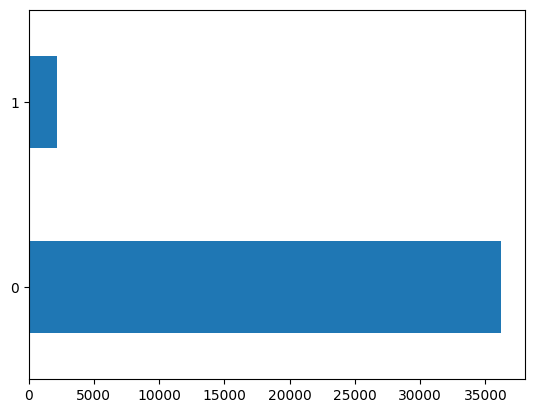

In [12]:
df_tr["target"].value_counts().plot(kind="barh");

In [13]:
def viz_pie(df):
    df["target"].value_counts().plot.pie(labels=["Normal", "AbNormal"], autopct=lambda x:f"{x:.2f}%");

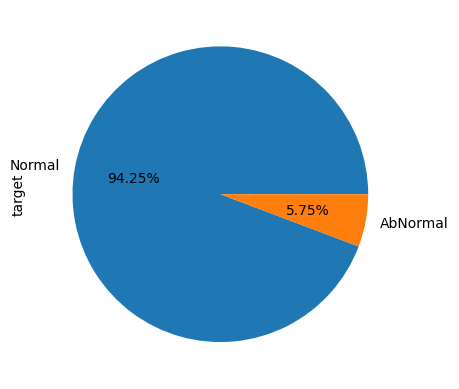

In [14]:
viz_pie(df_tr)

In [15]:
# ohe = ct.transformers_[0][1]
# ohe_cat_features = ohe.get_feature_names_out(cat_features)
# ohe_all_features = num_features + list(ohe_cat_features)

In [31]:
from sklearn.utils import resample
from imblearn.under_sampling import (NearMiss,
                                     ClusterCentroids,
                                     AllKNN,
                                     OneSidedSelection,
                                     TomekLinks)
from imblearn.over_sampling import (RandomOverSampler,
                                    SMOTE,
                                    ADASYN,
                                    SMOTENC,
                                    BorderlineSMOTE,
                                    KMeansSMOTE)

from imblearn.combine import SMOTEENN

def random_downsample(df, sample_ratio=1.0, random_seed=RANDOM_SEED):
    df_normal = df[df["target"] == 0] 
    df_abnormal = df[df["target"] == 1]
    
    downsampled = resample(
        df_normal,
        replace=False,
        n_samples=int(len(df_abnormal) * sample_ratio),
        random_state=random_seed
    )
    
    downsampled_df = pd.concat([df_abnormal, downsampled])
    
    return downsampled_df

def downsample(X, y, method, random_seed=RANDOM_SEED):
    # NearMiss
    if method == "nearmiss":
        nm = NearMiss(sampling_strategy="auto")
        X_downsampled, y_downsampled = nm.fit_resample(X, y)
    # ClusterCentroids
    elif method == "cluster":
        cc = ClusterCentroids(random_state=random_seed)
        X_downsampled, y_downsampled = cc.fit_resample(X, y)
    # AllKNN
    elif method == "allknn":
        allknn = AllKNN()
        X_downsampled, y_downsampled = allknn.fit_resample(X, y)
    # OneSidedSelection
    elif method == "oneside":
        oss = OneSidedSelection(random_state=random_seed)
        X_downsampled, y_downsampled = oss.fit_resample(X, y)
    # Tomeklinks
    elif method == "tomek":
        tl = TomekLinks()
        X_downsampled, y_downsampled = tl.fit_resample(X, y)
    
    X_downsampled_df= pd.DataFrame(X_downsampled, columns=all_features)
    y_downsampled_df = pd.Series(y_downsampled, name="target") 
    downsampled_df = pd.concat([X_downsampled_df, y_downsampled_df], axis=1)
    
    print('Original dataset shape %s' % Counter(y))
    print('Resampled dataset shape %s' % Counter(y_downsampled))
    
    return downsampled_df 

def upsample(X, y, cat_idx, method, random_seed=RANDOM_SEED):
    # X = df.drop("target", axis=1)
    # y = df["target"]
    
    if method == "random":
        ros = RandomOverSampler(random_state=random_seed)
        X_upsampled, y_upsampled = ros.fit_resample(X, y)
    # SMOTE
    if method == "smote":
        smote = SMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = smote.fit_resample(X, y)
    # ADASYN
    elif method == "adasyn":
        adasyn = ADASYN(random_state=random_seed)
        X_upsampled, y_upsampled = adasyn.fit_resample(X, y)
    # SMOTE-NC (both numerical & categorical features)
    elif method == "smotenc":
        smotenc = SMOTENC(random_state=random_seed, sampling_strategy="auto", categorical_features=cat_idx)
        X_upsampled, y_upsampled = smotenc.fit_resample(X, y)
    elif method == "borderline":
        borderline_smote = BorderlineSMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = borderline_smote.fit_resample(X, y)
    elif method == "kmeans":
        kmeans_smote = KMeansSMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = kmeans_smote.fit_resample(X, y)
        
    X_upsampled_df= pd.DataFrame(X_upsampled, columns=X_tr.columns)
    y_upsampled_df = pd.Series(y_upsampled, name="target") 
    upsampled_df = pd.concat([X_upsampled_df, y_upsampled_df], axis=1)
    
    print('Original dataset shape %s' % Counter(y))
    print('Resampled dataset shape %s' % Counter(y_upsampled))
    return upsampled_df

In [22]:
# downsampled_df = random_downsample(df, sample_ratio=3.0)
downsample_options = {1:"nearmiss", 2:"cluster", 3:"allknn", 4:"oneside", 5:"tomek"}

downsampled_df_tr = downsample(X_tr, y_tr, method=downsample_options[3])

Original dataset shape Counter({0: 36197, 1: 2210})
Resampled dataset shape Counter({0: 29931, 1: 2210})


In [23]:
downsampled_df_tr.columns[downsampled_df_tr.isnull().any()]

Index([], dtype='object')

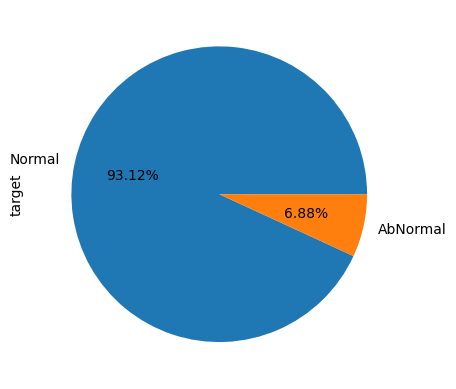

In [25]:
viz_pie(downsampled_df_tr)

In [26]:
downsampled_df_tr.tail()

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,HEAD Standby Position X Collect Result_Fill1,HEAD Standby Position Y Collect Result_Fill1,HEAD Standby Position Z Collect Result_Fill1,Head Clean Position X Collect Result_Fill1,Head Clean Position Y Collect Result_Fill1,Head Clean Position Z Collect Result_Fill1,Head Purge Position X Collect Result_Fill1,Head Purge P

In [32]:
upsample_options = {1: "random", 2:"smote", 3:"adasyn", 4:"smotenc", 5:"borderline", 6:"kmeans"}

cat_idx = [downsampled_df_tr.columns.get_loc(col) for col in cat_features]
X_tr = downsampled_df_tr.drop("target", axis=1)
y_tr = downsampled_df_tr["target"]

upsampled_df_tr = upsample(X_tr, y_tr, cat_idx, method=upsample_options[4])

Original dataset shape Counter({0: 29931, 1: 2210})
Resampled dataset shape Counter({0: 29931, 1: 29931})


In [37]:
upsampled_df_tr.isnull().sum()

CURE END POSITION X Collect Result_Dam         0
CURE END POSITION Z Collect Result_Dam         0
CURE SPEED Collect Result_Dam                  0
CURE START POSITION X Collect Result_Dam       0
CURE START POSITION Θ Collect Result_Dam       0
                                              ..
Machine Tact time Collect Result Bins_Fill2    0
PalletID Collect Result Bins_Fill2             0
Production Qty Collect Result Bins_Fill2       0
Receip No Collect Result Bins_Fill2            0
target                                         0
Length: 174, dtype: int64

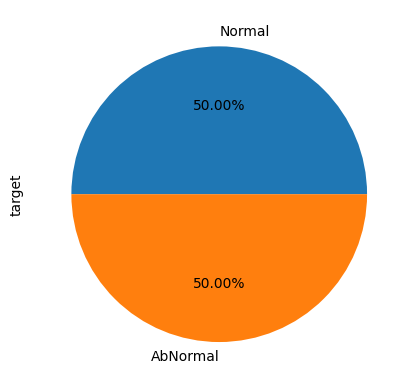

In [35]:
viz_pie(upsampled_df_tr)

In [36]:
upsampled_df_tr.tail()

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,HEAD Standby Position X Collect Result_Fill1,HEAD Standby Position Y Collect Result_Fill1,HEAD Standby Position Z Collect Result_Fill1,Head Clean Position X Collect Result_Fill1,Head Clean Position Y Collect Result_Fill1,Head Clean Position Z Collect Result_Fill1,Head Purge Position X Collect Result_Fill1,Head Purge P

### Submission

In [ ]:
from datetime import datetime

# df_pred = pd.DataFrame(, columns=["Set ID", "pred"])
# df_sub = pd.read_csv(os.path.join(ROOT_DIR, "submission.csv"))
# df_sub["target"] = df_sub["Set ID"].map(df_pred.set_index("Set ID")["pred"])
# df_sub.head()

In [ ]:
# curr_date = datetime.now().strftime("%m-%d_%H-%M-%S")
# df_sub.to_csv(os.path.join(ROOT_DIR, f"submission_{curr_date}.csv"))